# OSM Econ PS5: Rebekah Dix


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import scipy.special as sp
import scipy.integrate as integrate
import math

# Exercise 1

## Part (a)

In [2]:
# read in data
clms = pd.read_csv('clms.txt', header=None)
data = np.array(clms[0])

In [3]:
# Calculate and report the mean, median, maximum, minimum, 
# and standard deviation of monthly health expenditures for these data.
clms.describe()

,0
count,10619.000000
mean,720.277975
std,3972.850824
min,0.010000
25%,74.450000
50%,172.210000
75%,451.535000
max,227967.250000


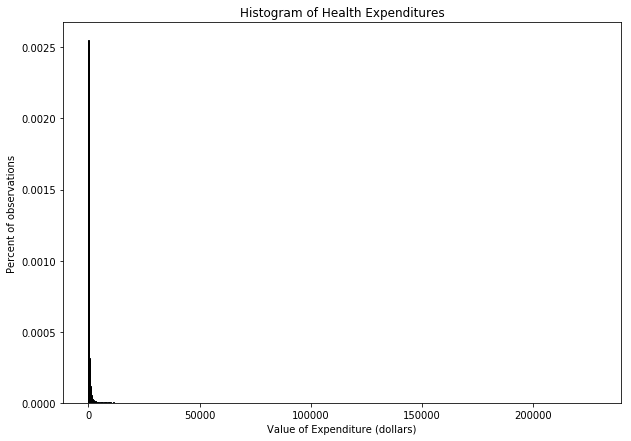

In [4]:
fig = plt.figure(figsize=(10,7))
density, bin_cuts, patches = plt.hist(data, 1000, density=True, edgecolor='k')
plt.title('Histogram of Health Expenditures')
plt.xlabel(r'Value of Expenditure (dollars)')
plt.ylabel(r'Percent of observations')
plt.show()

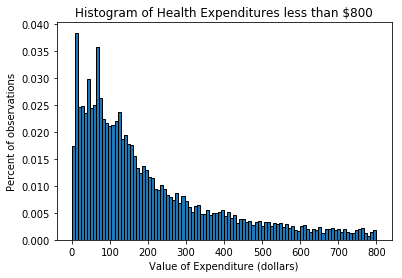

In [5]:
weights = (1 / data.shape[0]) * np.ones_like(data)
mask = data <= 800

n, bin_cuts, patches = plt.hist(data[mask], 100, weights=weights[mask], edgecolor='k')
plt.title('Histogram of Health Expenditures less than $800')
plt.xlabel(r'Value of Expenditure (dollars)')
plt.ylabel(r'Percent of observations')
plt.show()

The second histogram is much more informative. It still contains a majority of the data, but it excludes the outliers so that we are able to see the shape of the distribution (without outliers).

## Part (b)

In [6]:
# Define gamma distribution
def gamma_pdf(x, alpha, beta):
    f = (1 / (beta ** alpha * math.gamma(alpha))) * x ** (alpha - 1) * np.exp(-1 * x / beta)
    return f

In [7]:
# Define log likelihood function for the gamma distribution
def log_lik_gamma(xvals, alpha, beta):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given gamma
    distribution parameters alpha and beta.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the gamma distributed random
             variable
    alpha  = 
    beta   = 
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        sts.gamma.pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, gamma PDF values for alpha and beta
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of gamma PDF values
                  for alpha and beta corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: log_lik_val
    --------------------------------------------------------------------
    '''
    pdf_vals = gamma_pdf(xvals, alpha,beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [8]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([alpha, beta])
    alpha  = 
    beta   =
    args   = vector of xvals
    xvals  = (N,) vector, values of the gamma distributed random
             variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_gamma()
    
    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    alpha, beta = params
    xvals = args[0]
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [9]:
beta_init = clms.var() / clms.mean()  
alpha_init = clms.mean() / beta_init
params_init = np.array([alpha_init, beta_init])
results = opt.minimize(crit, params_init, args=data, 
                       method ='L-BFGS-B', bounds=((1e-5, None), (1e-5, None)))
alpha_MLE, beta_MLE = results.x
print('alpha_MLE=', alpha_MLE, ', beta_MLE=', beta_MLE)
MLE_ga = log_lik_gamma(data, alpha_MLE, beta_MLE)
print('MLE log-likelihood: ', MLE_ga)

alpha_MLE= 0.22175096367057023 , beta_MLE= 21913.1282767136
MLE log-likelihood:  -82076.64049645475


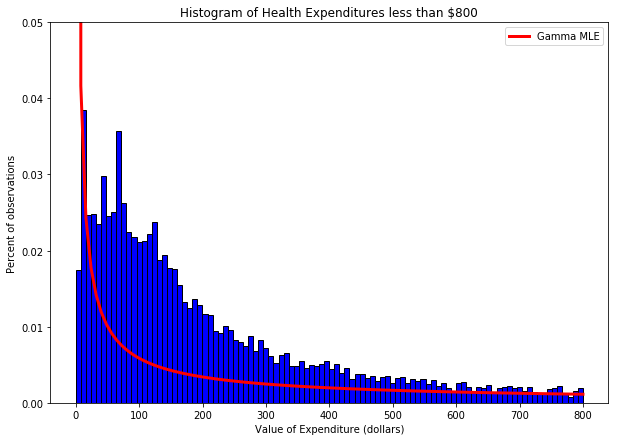

In [10]:
fig = plt.figure(figsize=(10,7))
# Plot MLE estimated distribution
dist_points = np.linspace(1e-5, 800, 100)
plt.plot(dist_points, 8 * gamma_pdf(dist_points, alpha_MLE, beta_MLE), lw=3, color='r',label='Gamma MLE')
# Plot data
weights = (1 / data.shape[0]) * np.ones_like(data)
mask = data <= 800
plt.hist(data[mask], 100, weights=weights[mask], color='b', edgecolor='k')
plt.title('Histogram of Health Expenditures less than $800')
plt.xlabel(r'Value of Expenditure (dollars)')
plt.ylabel(r'Percent of observations')
plt.ylim(0, .05)
plt.legend()
plt.show()

## Part (c)

In [11]:
def gen_gamma(x, alpha, beta, m):
    '''Define the pdf of the three-parameter generalized gamma distribution.'''
    f = (m / (beta ** alpha * math.gamma(alpha / m))) * x ** (alpha - 1) * np.exp( -1 * (x / beta) ** m)
    return f

In [12]:
# Define log likelihood function for the gamma distribution
def log_lik_gen_gamma(xvals, alpha, beta, m):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given generalized
    gamma distribution parameters alpha, beta, and m.
    --------------------------------------------------------------------
    '''
    pdf_vals = gen_gamma(xvals, alpha, beta, m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [13]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    '''
    alpha, beta, m = params
    xvals = args[0]
    log_lik_val = log_lik_gen_gamma(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [14]:
beta_init = beta_MLE
alpha_init = alpha_MLE
m_init = 1
params_init = np.array([alpha_init, beta_init, m_init])
results = opt.minimize(crit, params_init, args=data, 
                       method ='L-BFGS-B', bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
alpha_MLE1, beta_MLE1, m_MLE1 = results.x
print('alpha_MLE=', alpha_MLE, ', beta_MLE=', beta_MLE, ', m_MLE=', m_MLE1)
MLE_gga = log_lik_gen_gamma(data, alpha_MLE1, beta_MLE1, m_MLE1)
print('MLE log-likelihood: ', MLE_gga)

alpha_MLE= 0.22175096367057023 , beta_MLE= 21913.1282767136 , m_MLE= 0.9970557494972939
MLE log-likelihood:  -82076.63563075713


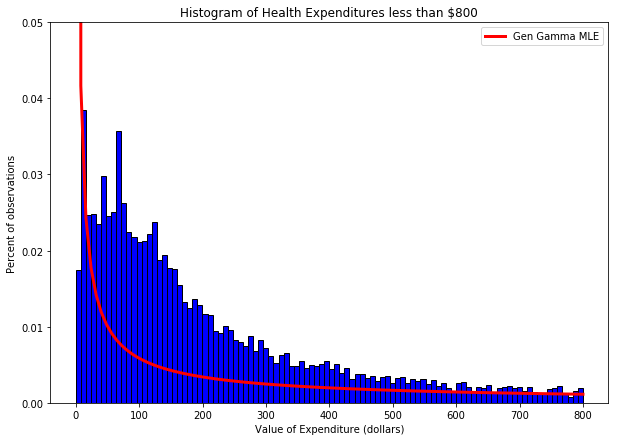

In [15]:
fig = plt.figure(figsize=(10,7))
# Plot MLE estimated distribution
dist_points = np.linspace(1e-5, 800, 100)
plt.plot(dist_points, 8 * gen_gamma(dist_points, alpha_MLE1, beta_MLE1, m_MLE1), lw=3, color='r',label='Gen Gamma MLE')
# Plot data
weights = (1 / data.shape[0]) * np.ones_like(data)
mask = data <= 800
plt.hist(data[mask], 100, weights=weights[mask], color='b', edgecolor='k')
plt.title('Histogram of Health Expenditures less than $800')
plt.xlabel(r'Value of Expenditure (dollars)')
plt.ylabel(r'Percent of observations')
plt.ylim(0, .05)
plt.legend()
plt.show()

## Part (d)

In [16]:
def gen_beta2(x, a, b, p, q):
    '''Define the pdf of the generalized beta 2 distribution.'''
    f = a * (x ** (a*p-1)) / ((b ** (a*p)) * sp.beta(p,q) * ((1 + (x / b) ** a) ** (p + q)))
    return f

In [17]:
# Define log likelihood function for the gamma distribution
def log_lik_gen_beta2(xvals, a, b, p, q):
    '''
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given generalized
    beta 2 distribution parameters a, b, p, q.
    --------------------------------------------------------------------
    '''
    pdf_vals = gen_beta2(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [18]:
def crit(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    '''
    a, b, p, q = params
    xvals = args[0]
    log_lik_val = log_lik_gen_beta2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [19]:
q_init = 200
b_init = (q_init**(1 / m_MLE1))*beta_MLE1
a_init = m_MLE1
p_init = alpha_MLE1 / m_MLE1

params_init = np.array([a_init, b_init, p_init, q_init])
results = opt.minimize(crit, params_init, args=data, 
                       method ='L-BFGS-B', bounds=((1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)))
a_MLE2, b_MLE2, p_MLE2, q_MLE2 = results.x
print('a_MLE=', a_MLE2, ', b_MLE=', b_MLE2, ', p_MLE=', p_MLE2, 'q_MLE', q_MLE2)
MLE_gb = log_lik_gen_beta2(data, a_MLE2, b_MLE2, p_MLE2, q_MLE2)
print('MLE log-likelihood: ', MLE_gb)

a_MLE= 0.10140179930831576 , b_MLE= 4451733.787558642 , p_MLE= 58.617003082332126 q_MLE 162.09427270840197
MLE log-likelihood:  -74874.4578040046


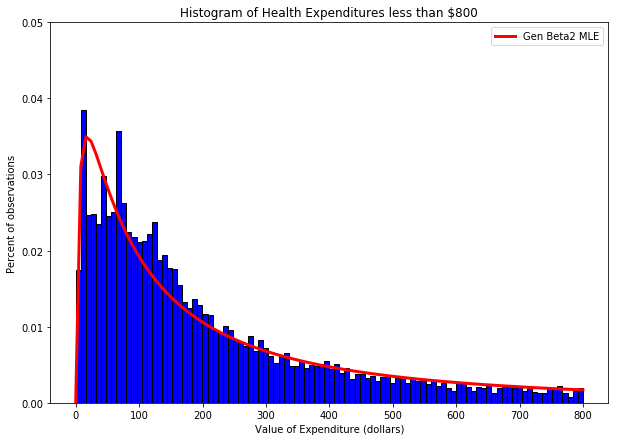

In [20]:
fig = plt.figure(figsize=(10,7))
# Plot MLE estimated distribution
dist_points = np.linspace(1e-5, 800, 100)
plt.plot(dist_points, 8 * gen_beta2(dist_points, a_MLE2, b_MLE2, p_MLE2, q_MLE2), lw=3, color='r',label='Gen Beta2 MLE')
# Plot data
weights = (1 / data.shape[0]) * np.ones_like(data)
mask = data <= 800
plt.hist(data[mask], 100, weights=weights[mask], color='b', edgecolor='k')
plt.title('Histogram of Health Expenditures less than $800')
plt.xlabel(r'Value of Expenditure (dollars)')
plt.ylabel(r'Percent of observations')
plt.ylim(0, .05)
plt.legend()
plt.show()

## Part (e)

In [21]:
def likelihood_ratio(lmin, lmax):
    return(2*abs((lmax-lmin)))

LR1 = likelihood_ratio(MLE_ga, MLE_gb)
p1 = 1 - sts.chi2.cdf(LR1, 4) 

LR2 = likelihood_ratio(MLE_gga, MLE_gb)
p2 = 1 - sts.chi2.cdf(LR2, 4)

print('chi squared of GA with GB2, 4 degrees of freedom, p-value = ', p1)
print('chi squared of GG with GB2, 4 degrees of freedom, p-value = ', p2)

chi squared of GA with GB2, 4 degrees of freedom, p-value =  0.0
chi squared of GG with GB2, 4 degrees of freedom, p-value =  0.0


## Part (f)

In [22]:
from scipy import integrate
prob_GB2 = integrate.quad(gen_beta2, 1000, np.inf, 
                          args = (a_MLE2, b_MLE2, p_MLE2, q_MLE2))
                                                              
prob_GA = integrate.quad(gamma_pdf, 1000, np.inf,
                              args = (alpha_MLE, beta_MLE))
print("Probability of GB2 of healthcare claim above 1000: ", prob_GB2[0])
print("Probability of GA of healthcare claim above 1000: ", prob_GA[0])

Probability of GB2 of healthcare claim above 1000:  0.13125109438748755
Probability of GA of healthcare claim above 1000:  0.4519639472347076


# Exercise 2

In [23]:
macro = pd.read_csv('MacroSeries.txt', header=None)
macro.columns = ['c', 'k', 'w', 'r', 'y']

In [24]:
macro.head()

,c,k,w,r,y
0,1.128323e+07,8.040697e+06,1.120211e+07,1.008852,1.931398e+07
1,1.215464e+07,8.030754e+06,1.206726e+07,1.088112,2.080561e+07
2,1.097303e+07,8.650974e+06,1.089414e+07,0.911904,1.878300e+07
3,9.711635e+06,7.809971e+06,9.641815e+06,0.893986,1.662382e+07
4,9.245673e+06,6.912184e+06,9.179203e+06,0.961637,1.582621e+07


## Part (a)

In [25]:
def calc_z(w, k, alpha):
    ''' Calculate z from w, k, and alpha.'''
    z = np.log(w / ((1 - alpha) * k ** alpha))
    
    return z

In [26]:
def log_lik_z(w, k, alpha, rho, mu, sigma):
    '''Return log likelihood of a series of z.'''
    z_series = calc_z(w, k, alpha)
    log_lik_val = 0
    for index, z_val in enumerate(z_series):
        if index == 0:
            pdf_val = sts.norm.pdf(mu, loc=mu, scale=sigma)
        else:
            pdf_val = sts.norm.pdf(z_val, loc=(rho * z_series[index-1] + (1 - rho)*mu), scale=sigma)
        ln_pdf_val = np.log(pdf_val)
        log_lik_val += ln_pdf_val
    
    return log_lik_val

In [27]:
def crit(params, *args):
    '''Compute the negative of the log likelihood function
    given parameters and data.'''
    alpha, rho, mu, sigma = params
    w, k = args
    log_lik_val = log_lik_z(w, k, alpha, rho, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [28]:
# Initial Guesses
alpha_init = .5
rho_init = .5
mu_init = 5
sig_init = .2
params_init = np.array([alpha_init, rho_init, mu_init, sig_init])
mle_args = (macro.w, macro.k)
results = opt.minimize(crit, params_init, args=mle_args, method ='L-BFGS-B', 
                             bounds=((1e-2, 0.99), (-0.99, 0.99), (1e-2, None), (1e-2, None)))
alpha_MLE, rho_MLE, mu_MLE, sig_MLE = results.x
log_like_val = results.fun
print('alpha_MLE= ', alpha_MLE, '\nrho_MLE= ', rho_MLE, '\nmu_MLE=', mu_MLE, ' \nsig_MLE=', sig_MLE)
print('Log-likelihood= ', results.fun)

alpha_MLE=  0.8246325243031751 
rho_MLE=  0.5534296043725 
mu_MLE= 4.809713117247751  
sig_MLE= 0.09278011396252836
Log-likelihood=  -95.85827568148886


In [29]:
# Inverse hessian variance-covariance matrix of your estimates.
vcv_mle = results.hess_inv.todense()
print(vcv_mle)

[[ 2.85057500e+01 -2.30945023e+01 -2.85272061e+02  8.24983371e-01]
 [-2.30945023e+01  6.05365846e+01  2.27728709e+02 -1.96439552e+00]
 [-2.85272061e+02  2.27728709e+02  2.85515326e+03 -8.15019258e+00]
 [ 8.24983371e-01 -1.96439552e+00 -8.15019258e+00  6.41748057e-02]]


## Part (b)

In [30]:
def calc_z(r, k, alpha):
    ''' Calculate z from r, k, and alpha.'''
    z = np.log(r / (alpha * k ** (alpha - 1)))
    
    return z

In [31]:
def log_lik_z(r, k, alpha, rho, mu, sigma):
    '''Return log likelihood of a series of z.'''
    z_series = calc_z(r, k, alpha)
    log_lik_val = 0
    for index, z_val in enumerate(z_series):
        if index == 0:
            pdf_val = sts.norm.pdf(mu, loc=mu, scale=sigma)
        else:
            pdf_val = sts.norm.pdf(z_val, loc=(rho * z_series[index-1] + (1 - rho)*mu), scale=sigma)
        ln_pdf_val = np.log(pdf_val)
        log_lik_val += ln_pdf_val
    
    return log_lik_val

In [32]:
def crit(params, *args):
    '''Compute the negative of the log likelihood function
    given parameters and data.'''
    alpha, rho, mu, sigma = params
    r, k = args
    log_lik_val = log_lik_z(r, k, alpha, rho, mu, sigma)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [33]:
# Initial Guesses
alpha_init = .8
rho_init = .5
mu_init = 5
sig_init = .1
params_init = np.array([alpha_init, rho_init, mu_init, sig_init])
mle_args = (macro.r, macro.k)
results = opt.minimize(crit, params_init, args=mle_args, method ='L-BFGS-B', 
                             bounds=((1e-2, 0.99), (-0.99, 0.99), (1e-2, None), (1e-2, None)))
alpha_MLE2, rho_MLE2, mu_MLE2, sig_MLE2 = results.x
log_like_val = results.fun
print('alpha_MLE= ', alpha_MLE2, '\nrho_MLE= ', rho_MLE2, '\nmu_MLE=', mu_MLE2, ' \nsig_MLE=', sig_MLE2)
print('Log-likelihood= ', results.fun)

alpha_MLE=  0.5533866818665817 
rho_MLE=  0.8246552488578388 
mu_MLE= 7.569642029480069  
sig_MLE= 0.09278046258725611
Log-likelihood=  -95.85827567964951


In [34]:
# Inverse hessian variance-covariance matrix of your estimates.
vcv_mle = results.hess_inv.todense()
print(vcv_mle)

[[ 1.02332040e+00  2.14818179e+00 -1.77912062e+01 -1.11073817e-01]
 [ 2.14818179e+00  5.56176158e+00 -3.75377718e+01 -2.95681552e-01]
 [-1.77912062e+01 -3.75377718e+01  3.09359306e+02  1.94333581e+00]
 [-1.11073817e-01 -2.95681552e-01  1.94333581e+00  1.59281768e-02]]


## Part (c)

In [35]:
def get_zstar(k, alpha):
    return np.log(1 / (alpha * k ** (alpha - 1)))
zstar = get_zstar(7500000, alpha_MLE)
prob = sts.norm.cdf(zstar, loc=(rho_MLE * 10 + (1 - rho_MLE) * mu_MLE), scale=sig_MLE)
res = 1 - prob
print(prob, res)

0.0 1.0


The probability that the interest rate this period will be greater than one under these conditions is very close to one.

## Exercise 3

In [36]:
incomes = np.loadtxt('usincmoms.txt', delimiter='\t')
percent = incomes[:,0]
midpoint = incomes[:,1]
avg_inc = np.mean(percent @ midpoint)

### Part (a)

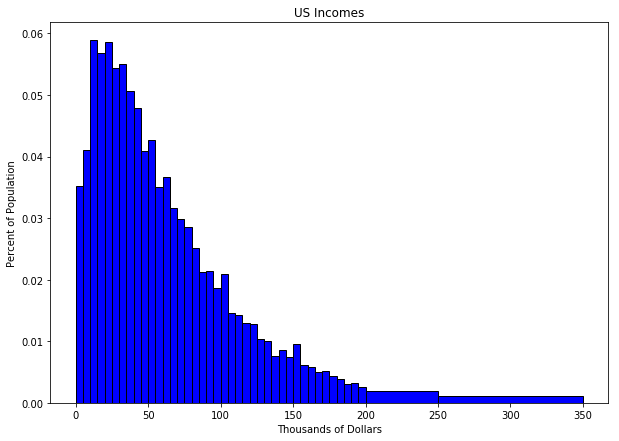

In [37]:
fig = plt.figure(figsize=(10,7))

# Adjust the height of the final two bars of the income distribution
modified_height = np.copy(percent)
modified_height[40] = modified_height[40]/10
modified_height[41] = modified_height[41]/20
widtharr = 5 * np.ones(42)
widtharr[40] *= 10
widtharr[41] *= 20

plt.bar(midpoint/1000, modified_height, color='blue', edgecolor='k', align='center', width=widtharr)
plt.xlabel('Thousands of Dollars')
plt.ylabel('Percent of Population')
plt.title('US Incomes')
plt.show()

## Part (b)

In [38]:
# Define bin upper bounds
bins = np.zeros(42, dtype=np.float64)

# Edge case
bins[0] = 5000

# Middle range:
for i in range(1, 40):
    bins[i] = (midpoint[i] + midpoint[i+1])/2
   
# Adjust top end of distribution
bins[39] = 200000
bins[40] = 250000
bins[41] = np.inf

In [39]:
bins

array([  5000.,  10000.,  15000.,  20000.,  25000.,  30000.,  35000.,
        40000.,  45000.,  50000.,  55000.,  60000.,  65000.,  70000.,
        75000.,  80000.,  85000.,  90000.,  95000., 100000., 105000.,
       110000., 115000., 120000., 125000., 130000., 135000., 140000.,
       145000., 150000., 155000., 160000., 165000., 170000., 175000.,
       180000., 185000., 190000., 195000., 200000., 250000.,     inf])

In [40]:
def log_normal(x, mu, sigma):
    ''' Define the pdf of the lognormal distribution.'''
    pdf_val = (1/(x*sigma * np.sqrt(2 * np.pi)) *
                    np.exp(-(np.log(x) - mu)**2 /(2 * sigma**2)))
    return pdf_val

In [41]:
def model_moments(bins, mu, sigma):
    ''' This function computes the model moments for GMM. 
    We find the percentage of households in each bin using
    the lognormal distribution.'''
    
    pdf_vals = np.zeros(42, dtype=np.float64)
    # Right side value:
    dist_1 = sts.norm.cdf(np.log(bins), mu, sigma)
    
    # Left side value:
    bins_2 = np.roll(bins, 1)
    bins_2[0] = 1e-10
    dist_2 = sts.norm.cdf(np.log(bins_2), mu, sigma)
    
    pdf_vals = dist_1 - dist_2
    
    return pdf_vals 


def err_vec(bins, percents, mu, sigma, simple):
    '''Computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.'''

    moms_data = percents
    moms_model = model_moments(bins, mu, sigma)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''Define criterion function.'''
    mu, sigma = params
    bins, percents, W = args
    err = err_vec(bins, percents, mu, sigma, False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [42]:
mu_init = np.log(avg_inc)
sig_init = 1
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(percent)
gmm_args = (bins, percent, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print(results)

mu_GMM1= 10.766843376404815  sig_GMM1= 0.9078416946691477
      fun: 0.045945282528995955
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.44383460e-07,  1.27814426e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([10.76684338,  0.90784169])


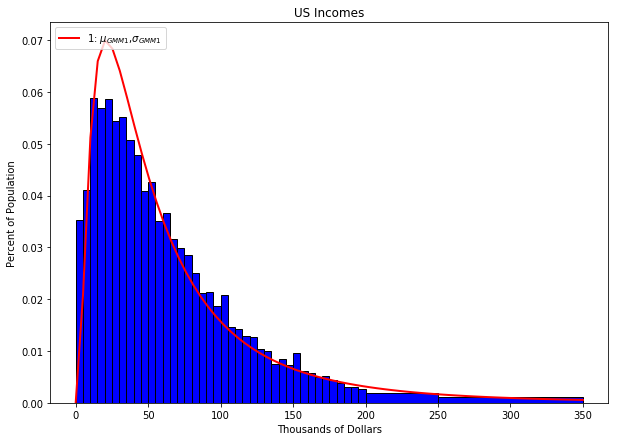

In [43]:
fig = plt.figure(figsize=(10,7))
plt.bar(midpoint/1000, modified_height, color='blue', edgecolor='k', align='center', width=widtharr)
plt.xlabel('Thousands of Dollars')
plt.ylabel('Percent of Population')
plt.title('US Incomes')

# Plot the estimated GMMPDF
x = np.linspace(1e-5,350000,70)
y = 5e3 * log_normal(x, mu_GMM1, sig_GMM1)
plt.plot(x/1000, y,
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

## Part (c)

In [44]:
# Define gamma distribution
def gamma_pdf(x, alpha, beta):
    f = (1 / (beta ** alpha * math.gamma(alpha))) * x ** (alpha - 1) * np.exp(-1 * x / beta)
    return 5000 * f

In [45]:
def err_vec(midpoint, percents, alpha, beta, simple):
    '''Computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.'''

    moms_data = percents
    moms_model = gamma_pdf(midpoint, alpha, beta)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''Define criterion function.'''
    alpha, beta = params
    percents, W = args
    err = err_vec(midpoint, percents, alpha, beta, False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [46]:
alpha_init = 1.5
beta_init = 10000
params_init = np.array([alpha_init, beta_init])
W_hat = np.diag(percent)
gmm_args = (percent, W_hat)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))

alpha_GMM_1, beta_GMM_1 = results.x

results

      fun: 0.04400238767191182
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.67008637e-06, -6.93889390e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 114
      nit: 35
   status: 0
  success: True
        x: array([1.42455023e+00, 4.50501213e+04])

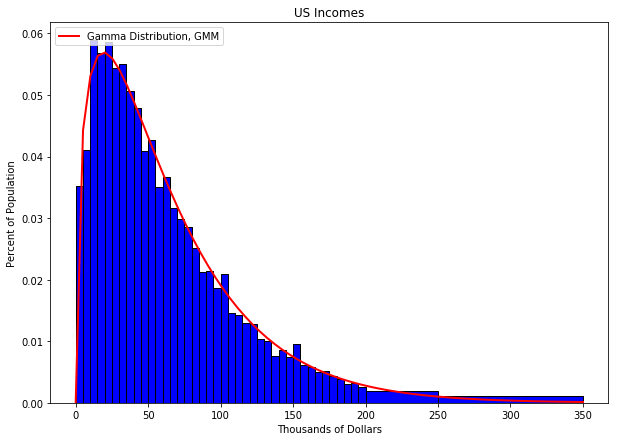

In [47]:
fig = plt.figure(figsize=(10,7))
plt.bar(midpoint/1000, modified_height, color='blue', edgecolor='k', align='center', width=widtharr)
plt.xlabel('Thousands of Dollars')
plt.ylabel('Percent of Population')
plt.title('US Incomes')

# Plot the estimated GMMPDF
x = np.linspace(1e-5,350000,70)
y = gamma_pdf(x, alpha_GMM_1, beta_GMM_1)
plt.plot(x/1000, y,
         linewidth=2, color='r', label='Gamma Distribution, GMM')
plt.legend(loc='upper left')
plt.show()

## Part (d)

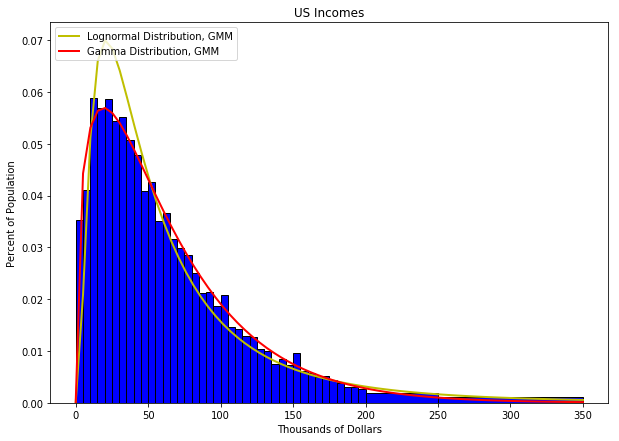

In [48]:
fig = plt.figure(figsize=(10,7))
plt.bar(midpoint/1000, modified_height, color='blue', edgecolor='k', align='center', width=widtharr)
plt.xlabel('Thousands of Dollars')
plt.ylabel('Percent of Population')
plt.title('US Incomes')

# Plot the estimated GMMPDF
x = np.linspace(1e-5,350000,70)
y = 5e3 * log_normal(x, mu_GMM1, sig_GMM1)
plt.plot(x/1000, y,
         linewidth=2, color='y', label='Lognormal Distribution, GMM')

x = np.linspace(1e-5,350000,70)
y = gamma_pdf(x, alpha_GMM_1, beta_GMM_1)
plt.plot(x/1000, y,
         linewidth=2, color='r', label='Gamma Distribution, GMM')
plt.legend(loc='upper left')
plt.show()

The gamma distribution appears to better fit the data. The lognormal distribution seems to overestimate the percentage of households in the lower end of the income distribution.

## Part (e)

In [49]:
alpha_init = 3.0
beta_init = 20000

params_init = np.array([alpha_init, beta_init])
gmm_args = (percent, np.eye(42))
results_Iden = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))

alpha_GMM_Iden, beta_GMM_Iden = results_Iden.x

W_hat2 = (1/42) * (err_vec(midpoint, percent, alpha_GMM_Iden, beta_GMM_Iden, False) @ err_vec(midpoint, percent,  alpha_GMM_Iden,  beta_GMM_Iden, False))

gmm_args = (percent, W_hat2)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))

alpha_GMM_2, beta_GMM_2 = results.x
results

      fun: 0.10768539974742597
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.56419363e-07,  0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 117
      nit: 32
   status: 0
  success: True
        x: array([1.42614856e+00, 4.42116021e+04])

In [50]:
print(alpha_GMM_1, alpha_GMM_2)

1.4245502269375907 1.4261485580715665


In [51]:
print(beta_GMM_1, beta_GMM_2)

45050.121259278676 44211.602096273586


The estimates for alpha are nearly identical. The estimates for beta differ slightly, but we would expect this since the scale for beta is different than that for alpha. We can caompre the criterion function values to compare the goodness of ﬁt of this estimated distribution versus the goodness of ﬁt of the estimated distribution in part (c). The estimated distribution in part (c) actually has a smaller criterion function value.

# Exercise 4

In [52]:
macro = pd.read_csv('MacroSeries.txt', header=None)
macro.columns = ['c', 'k', 'w', 'r', 'y']

In [53]:
macro.head()

,c,k,w,r,y
0,1.128323e+07,8.040697e+06,1.120211e+07,1.008852,1.931398e+07
1,1.215464e+07,8.030754e+06,1.206726e+07,1.088112,2.080561e+07
2,1.097303e+07,8.650974e+06,1.089414e+07,0.911904,1.878300e+07
3,9.711635e+06,7.809971e+06,9.641815e+06,0.893986,1.662382e+07
4,9.245673e+06,6.912184e+06,9.179203e+06,0.961637,1.582621e+07


In [54]:
def calc_z(r, k, alpha):
    ''' Calculate z from r, k, and alpha.'''
    z = np.log(r / (alpha * k ** (alpha - 1)))
    
    return z

In [55]:
def data_moments(params, data):
    '''
    --------------------------------------------------------------------
    This function computes the data moments for GMM.
    --------------------------------------------------------------------
    '''
    alpha, beta, rho, mu = params
    
    
    # Extract capital series
    kt = data.k
    ktp1 = np.roll(kt, 1)
    
    # Extract wage series
    wt = data.w
    
    # Extract consumption series
    ct = data.c
    ctp1 = np.roll(ct, 1)
    
    # Extract interest rate series
    rt = data.r
    
    # Calculate z series from data
    zt = calc_z(rt, kt, alpha)
    ztp1 = np.roll(zt, 1)
    
    datamoments = calc_moments(params, zt, ztp1, ct, ctp1, ktp1, wt)
    datamoments[0][0] = 0
    datamoments[1][0] = 0
    datamoments[2][0] = 0
    datamoments[3][0] = 0
    
    moment_vec = np.array([np.mean(datamoments[0]), np.mean(datamoments[1]), 
                           np.mean(datamoments[2]), np.mean(datamoments[3])])
    
    return moment_vec


def calc_moments(params, zt, ztp1, ct, ctp1, ktp1, wt):
    '''
    --------------------------------------------------------------------
    This function computes the model moments for GMM.
    --------------------------------------------------------------------
    '''
    alpha, beta, rho, mu = params
    
    moment1 = ztp1 - rho * zt - (1 - rho) * mu
    moment2 = (ztp1 - rho * zt - (1 - rho) * mu) * zt
    moment3 = (beta * alpha * np.exp(ztp1) * ktp1 ** (alpha - 1) * (ct / ctp1) - 1)
    moment4 = (beta * alpha * np.exp(ztp1) * ktp1 ** (alpha - 1) * (ct / ctp1) - 1) * wt
    
    return moment1, moment2, moment3, moment4


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    '''
    alpha, beta, rho, mu = params
    data, W = args
    err = data_moments(params, data)
    crit_val = err.T @ W @ err
    
    return crit_val

In [56]:
# Initial guess
alpha = .1
beta = .2
rho = .2
mu = 5
params_guess = (alpha, beta, rho, mu)
W = np.eye(4)
args = macro, W

results = opt.minimize(criterion, params_guess, args=args, method = 'L-BFGS-B', 
                       bounds=((1e-10, 1), (1e-10, 1), (-1, 1), (1e-10, None)))
results

      fun: 0.0025364869650749545
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.75967197e-03,  1.35461287e+02, -3.99814730e-06, -2.99354205e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 390
      nit: 39
   status: 0
  success: True
        x: array([0.70295431, 0.96740341, 0.39778351, 5.0138766 ])

# Exercise 5: Revisit this later